# 1.1 📄 Problem Statement

Most wearable health devices collect useful metrics (e.g., heart rate, SpO₂, activity level), but they often fail to interpret this data intelligently or alert users about potential issues. There is a growing need for an AI-powered system that can:

    Continuously monitor health data in real time

    Detect abnormal health patterns or events early

    Deliver personalized, easy-to-understand recommendations

This system will bridge the gap between raw health data and timely, actionable insights.


# 1.2 🎯 Objectives
Objective #	Description
1️⃣	Detect anomalies in key health metrics using AI
2️⃣	Provide personalized recommendations to guide user behavior
3️⃣	Visualize trends over time for better self-awareness


# 1.3 🧍 Target Users
User Type	Description
Health-conscious individuals	People who use wearables to track fitness and wellness
Patients with chronic conditions	Elderly or recovering individuals who need early alerts
Future phase: Community Health Workers	Professionals monitoring multiple patients remotely


# 1.4 📊 Key Metrics to Monitor

    Heart Rate (BPM)

    Blood Oxygen Saturation (SpO₂ %)

    Activity Level (categorical: low/moderate/high)

    (Future): Sleep Quality, Respiratory Rate, Skin Temp



# 1.5 🧭 In Scope (Phase 1)

    Data simulation or use of open wearable data

    Anomaly detection and simple health risk classification

    Flask-based dashboard or alerting logic

    Offline-ready logic for mobile sync


# 1.6 🚫 Out of Scope (Phase 1)

    No emergency response (e.g., calling ambulance)

    No live integration with Fitbit, Apple Health APIs (yet)

    No diagnostics or medical decision-making




In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Set seed for reproducibility
np.random.seed(42)

# Simulate 7 days of minute-level data (≈ 10,080 minutes)
n = 7 * 24 * 60

# Generate wearable data
df = pd.DataFrame({
    'timestamp': pd.date_range(start='2025-06-20 00:00', periods=n, freq='T'),
    'heart_rate': np.random.normal(loc=75, scale=12, size=n).astype(int),
    'blood_oxygen': np.random.normal(loc=96.5, scale=1.8, size=n).astype(int),
    'activity_level': np.random.choice(['low', 'moderate', 'high'], size=n, p=[0.5, 0.35, 0.15])
})

# Inject anomalies (simulate "risky" readings)
df.loc[np.random.choice(n, size=300, replace=False), 'heart_rate'] += np.random.randint(20, 40, size=300)
df.loc[np.random.choice(n, size=200, replace=False), 'blood_oxygen'] -= np.random.randint(5, 10, size=200)

# Add a risk label: 1 = abnormal, 0 = normal
df['risk'] = ((df['heart_rate'] > 100) | (df['blood_oxygen'] < 92)).astype(int)

# Handle missing values: randomly remove 1% values
for col in ['heart_rate', 'blood_oxygen']:
    idx = np.random.choice(df.index, size=int(0.01 * n), replace=False)
    df.loc[idx, col] = np.nan

# Impute missing values
df['heart_rate'].fillna(df['heart_rate'].mean(), inplace=True)
df['blood_oxygen'].fillna(method='ffill', inplace=True)

# Encode categorical activity level
df['activity_encoded'] = df['activity_level'].map({'low': 0, 'moderate': 1, 'high': 2})

# Normalize numeric features
scaler = MinMaxScaler()
df[['heart_rate_norm', 'blood_oxygen_norm']] = scaler.fit_transform(df[['heart_rate', 'blood_oxygen']])

# Final preview
print(df.head())
print(f"\nTotal records: {len(df)}")
print(df['risk'].value_counts())


            timestamp  heart_rate  blood_oxygen activity_level  risk  \
0 2025-06-20 00:00:00        80.0          99.0       moderate     0   
1 2025-06-20 00:01:00       112.0          94.0           high     1   
2 2025-06-20 00:02:00        82.0          96.0            low     0   
3 2025-06-20 00:03:00        93.0          99.0       moderate     0   
4 2025-06-20 00:04:00        72.0          97.0            low     0   

   activity_encoded  heart_rate_norm  blood_oxygen_norm  
0                 1         0.473214           0.761905  
1                 2         0.758929           0.523810  
2                 0         0.491071           0.619048  
3                 1         0.589286           0.761905  
4                 0         0.401786           0.666667  

Total records: 10080
risk
0    9526
1     554
Name: count, dtype: int64


/tmp/ipython-input-1-769979190.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2025-06-20 00:00', periods=n, freq='T'),
/tmp/ipython-input-1-769979190.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].fillna(df['heart_rate'].mean(), inplace=True)
/tmp/ipython-input-1-769979190.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Th

In [2]:
# Optional: Save to disk
df.to_csv("weeklong_health_data.csv", index=False)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Features and target
X = df[['heart_rate', 'blood_oxygen', 'activity_encoded']]
y = df['risk']

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1905    0]
 [   0  111]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1905
           1       1.00      1.00      1.00       111

    accuracy                           1.00      2016
   macro avg       1.00      1.00      1.00      2016
weighted avg       1.00      1.00      1.00      2016



In [4]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1905
           1       1.00      1.00      1.00       111

    accuracy                           1.00      2016
   macro avg       1.00      1.00      1.00      2016
weighted avg       1.00      1.00      1.00      2016



In [5]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Prepare features (drop timestamps for LSTM)
features = df[['heart_rate', 'blood_oxygen', 'activity_encoded']].copy()

# Normalize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create sequences (look back 10 timesteps)
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(df['risk'].iloc[i + lookback])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_features)

# Split
split = int(0.8 * len(X_seq))
X_train_lstm, X_test_lstm = X_seq[:split], X_seq[split:]
y_train_lstm, y_test_lstm = y_seq[:split], y_seq[split:]

# Build LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate
loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Test Accuracy: {accuracy:.2f}")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8486 - loss: 0.4491 - val_accuracy: 0.9392 - val_loss: 0.2286
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9468 - loss: 0.2094 - val_accuracy: 0.9392 - val_loss: 0.2285
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9480 - loss: 0.2064 - val_accuracy: 0.9392 - val_loss: 0.2311
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9483 - loss: 0.2043 - val_accuracy: 0.9392 - val_loss: 0.2289
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9480 - loss: 0.2055 - val_accuracy: 0.9392 - val_loss: 0.2291
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9446 - loss: 0.2144
LSTM Test Accuracy: 0.95


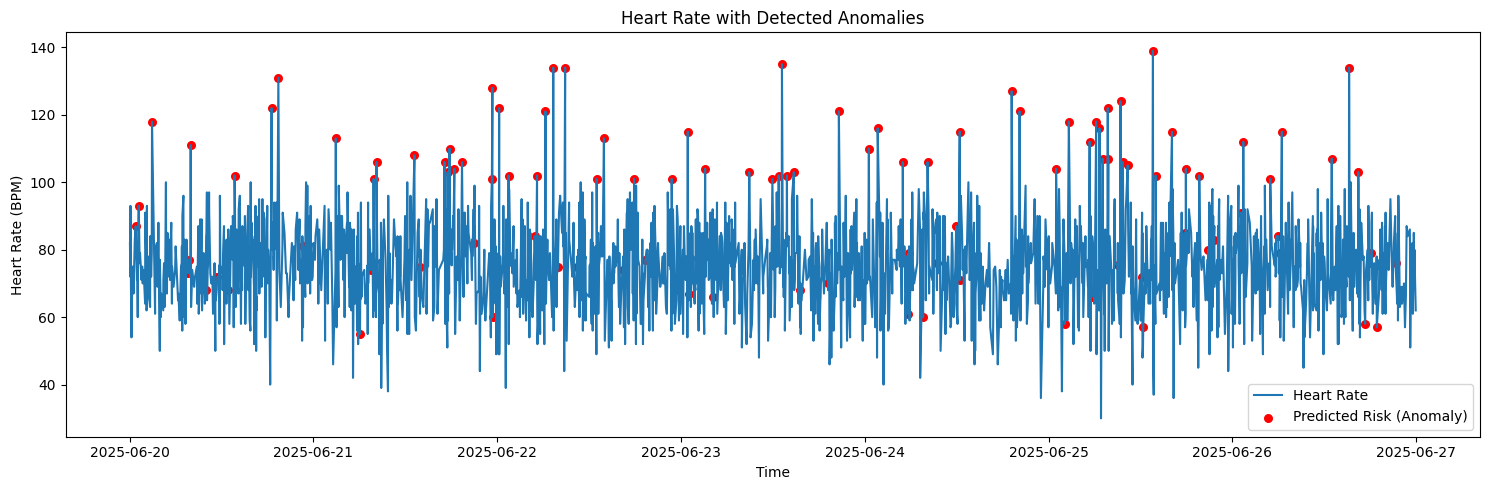

In [6]:
import matplotlib.pyplot as plt

# Add predictions back to main DataFrame for plotting
df_test = X_test.copy()
df_test['risk_true'] = y_test
df_test['risk_pred'] = y_pred
df_test['timestamp'] = df.loc[df_test.index]['timestamp'].values

# Sort by time for line plotting
df_test = df_test.sort_values('timestamp')

# Plot heart rate with anomalies
plt.figure(figsize=(15,5))
plt.plot(df_test['timestamp'], df_test['heart_rate'], label='Heart Rate')
plt.scatter(
    df_test[df_test['risk_pred'] == 1]['timestamp'],
    df_test[df_test['risk_pred'] == 1]['heart_rate'],
    color='red', label='Predicted Risk (Anomaly)', s=30
)
plt.title("Heart Rate with Detected Anomalies")
plt.xlabel("Time")
plt.ylabel("Heart Rate (BPM)")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1905
           1       1.00      1.00      1.00       111

    accuracy                           1.00      2016
   macro avg       1.00      1.00      1.00      2016
weighted avg       1.00      1.00      1.00      2016



In [8]:
import os

# Step 1: Create the templates directory
if not os.path.exists("templates"):
    os.makedirs("templates")
    print("✅ 'templates/' folder created.")

# Step 2: Create the index.html file
html_code = '''<!DOCTYPE html>
<html>
<head>
    <title>Health Dashboard</title>
    <style>
        body {
            font-family: sans-serif;
            padding: 40px;
            background: #f5f5f5;
        }
        .card {
            background: white;
            border-radius: 10px;
            padding: 20px;
            max-width: 500px;
            margin: auto;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        }
        h2 { color: #2a2a2a; }
        p { font-size: 1.2em; }
        .status { font-weight: bold; font-size: 1.5em; }
    </style>
</head>
<body>
    <div class="card">
        <h2>🧠 Real-Time Health Dashboard</h2>
        <p><strong>Time:</strong> {{ timestamp }}</p>
        <p><strong>Heart Rate:</strong> {{ heart_rate }} BPM</p>
        <p><strong>Oxygen Level:</strong> {{ spo2 }} %</p>
        <p><strong>Activity Level:</strong> {{ activity }}</p>
        <p class="status">Status: {{ status }}</p>
        <p><strong>Recommendation:</strong><br>{{ recommendation }}</p>
    </div>
</body>
</html>'''

with open("templates/index.html", "w") as f:
    f.write(html_code)
    print("✅ index.html created in 'templates/'.")

# Step 3: (Optional) Print instructions
print("\n✅ All set! Now run `app.py` or paste the full Flask code to start your dashboard.")


✅ 'templates/' folder created.
✅ index.html created in 'templates/'.

✅ All set! Now run `app.py` or paste the full Flask code to start your dashboard.


In [ ]:
from flask import Flask, render_template
import pandas as pd

app = Flask(__name__)

def generate_recommendation(hr, spo2, activity):
    if hr > 100 and spo2 < 92:
        return "🚨 Seek medical attention immediately."
    elif hr > 90:
        return "⚠️ Elevated heart rate. Consider rest or hydration."
    elif spo2 < 95:
        return "🫁 Low oxygen detected. Try deep breathing and avoid exertion."
    elif activity == "low":
        return "🏃‍♂️ You’ve been inactive. A short walk could help your health."
    else:
        return "✅ All vitals are normal. Keep it up!"

@app.route('/')
def dashboard():
    # Load recent data
    df = pd.read_csv("weeklong_health_data.csv")
    latest = df.tail(1).squeeze()  # latest record

    # Interpret status and recommendation
    status = "⚠️ Risk" if latest['risk'] == 1 else "✅ Normal"
    recommendation = generate_recommendation(
        latest['heart_rate'], latest['blood_oxygen'], latest['activity_level']
    )

    return render_template(
        'index.html',
        heart_rate=int(latest['heart_rate']),
        spo2=int(latest['blood_oxygen']),
        activity=latest['activity_level'].capitalize(),
        status=status,
        recommendation=recommendation,
        timestamp=latest['timestamp']
    )

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
 ## Unit Testing (Model & Preprocessing)

# Create a test_pipeline.py file:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def test_data_loading():
    df = pd.read_csv("weeklong_health_data.csv")
    assert not df.empty, "❌ Data failed to load"
    print("✅ Data loaded successfully.")

def test_model_training():
    df = pd.read_csv("weeklong_health_data.csv")
    X = df[['heart_rate', 'blood_oxygen', 'activity_encoded']]
    y = df['risk']
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    assert model.score(X_train, y_train) > 0.7, "❌ Model underperforming on training data"
    print("✅ Model training successful and accurate.")

if __name__ == "__main__":
    test_data_loading()
    test_model_training()


In [ ]:
# User Testing (Feedback Collection)
@app.route('/feedback', methods=['POST'])
def feedback():
    user = request.form['user']
    message = request.form['message']
    with open("feedback_log.txt", "a") as f:
        f.write(f"{user}: {message}\n")
    return "✅ Feedback received! Thank you."

# And add a form to index.html:

<form method="POST" action="/feedback">
  <input type="text" name="user" placeholder="Your name" required>
  <br>
  <textarea name="message" placeholder="Your feedback" required></textarea>
  <br>
  <button type="submit">Send Feedback</button>
</form>


In [ ]:
## API Deployment (RESTful Flask API)

# Create api.py for REST API:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

model = joblib.load("random_forest_model.pkl")  # Save earlier model using joblib.dump()

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    df = pd.DataFrame([data])
    prediction = model.predict(df)[0]
    return jsonify({"risk": int(prediction)})

if __name__ == '__main__':
    app.run(debug=True)
